<a href="https://colab.research.google.com/github/RDelg/rl-book/blob/master/chapter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from functools import lru_cache

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [0]:
class Env():
    class ObsSpace:
        _space = [2]
        _min = 0
        _max = 20
  
    class ActionSpace:
        _space = [1]
        _min = -5
        _max = 5

    # Rental car information
    _lam_in_a = 3
    _lam_out_a = 3
    _lam_in_b = 4
    _lam_out_b = 2

    # How many values of the Poisson distributtion use to calculate the
    # dynamics
    _poisson_range = 11
    _return_a = poisson.pmf(range(_poisson_range), _lam_in_a)
    _request_a = poisson.pmf(range(_poisson_range), _lam_out_a)
    _return_b = poisson.pmf(range(_poisson_range), _lam_in_b)
    _request_b = poisson.pmf(range(_poisson_range), _lam_out_b)

    _obs_space = ObsSpace()
    _act_space = ActionSpace()

    # Reward values
    _move_reward = -2
    _rental_reward = 10

    def __init__(self, gamma=0.9, fixed_return=True):
        self.gamma = gamma
        self.fixed_return = fixed_return
        self.obs_space_range = self._obs_space._max - self._obs_space._min + 1
        self.action_space_range = self._act_space._max - self._act_space._min + 1
        self.action_probability = 1./self.action_space_range
        self.obs_space_shape = [
            self.obs_space_range for _ in range(self._obs_space._space[0])
        ]
        self.eps = 0.001
        self.reset()

    def reset(self):
        self.value = np.zeros(shape=self.obs_space_shape)
        self.policy = np.zeros(shape=self.obs_space_shape, dtype=np.int32)
    
    @staticmethod
    @lru_cache(maxsize=None)
    def legal_actions(state):
        return np.arange(
            np.max([-state[1], Env._act_space._min]),
            np.min([state[0], Env._act_space._max]) + 1,
            1,
            dtype=np.int32)

    
    def dynamics(self, state, action):
        value = 0.
        reward_base = np.abs(action) * np.float32(self._move_reward)
        state = list(state)
        state[0] -= action
        state[1] += action

        for request_a in np.arange(self._poisson_range, dtype=np.int32):
            request_a_prob = self._request_a[request_a]
            for request_b in np.arange(self._poisson_range, dtype=np.int32):
                request_b_prob = self._request_b[request_b]

                real_request_a = np.min([request_a, state[0]])
                real_request_b = np.min([request_b, state[1]])
                
                reward = (
                    reward_base + np.float32(self._rental_reward) * (
                        real_request_a + real_request_b)
                )

                prob = (request_a_prob*request_b_prob)

                if self.fixed_return:
                    return_a = self._lam_in_a
                    return_b = self._lam_in_b
                    new_state = (
                        np.min([state[0] - real_request_a + return_a, self._obs_space._max]),
                        np.min([state[1] - real_request_b + return_b, self._obs_space._max]))
                    value += prob*(reward + self.gamma*self.value[new_state[0], new_state[1]])
                else:
                    for return_a in np.arange(self._poisson_range, dtype=np.int32):
                        return_a_prob = self._return_a[return_a]
                        for return_b in np.arange(self._poisson_range, dtype=np.int32):
                            return_b_prob = self._return_b[return_b]
                            _prob = prob*return_a_prob*return_b_prob
                            new_state = (
                                np.min([state[0] - real_request_a + return_a, self._obs_space._max]),
                                np.min([state[1] - real_request_b + return_b, self._obs_space._max]))
                            value += _prob*(reward + self.gamma*self.value[new_state[0], new_state[1]])

        return value

    def policy_improvement(self):
        print('Running policy improvement')
        stable = True
        with np.nditer(
            [self.policy],
            flags=['multi_index'],
            op_flags=[['readwrite']]) as it:
            while not it.finished:
                old_action = np.int32(it[0])
                actions = self.legal_actions(it.multi_index)
                q = np.zeros_like(actions, dtype=np.float32)
                for a, action in enumerate(actions):
                    q[a] += self.dynamics(it.multi_index, action)
                it[0][...] = actions[np.argmax(q)]
                if np.int32(it[0]) != old_action:
                    stable = False
                it.iternext()
        return stable
    
    def policy_evaluation(self):
        print('Running policy evaluation')
        converged = False
        while not converged:
            old_value = self.value.copy()
            with np.nditer(
                [self.value, self.policy],
                flags=['multi_index'],
                op_flags=[['readwrite'],['readonly']]) as it:
                while not it.finished:
                    it[0][...] = self.dynamics(it.multi_index, it[1])
                    it.iternext()
            max_diff = np.max(np.abs(self.value - old_value))
            print(f'Max diff: {max_diff}')
            if max_diff < self.eps:
                converged = True
                print('Converged')
    
    def plot_policy(self, ax=None, figsize=(6,6)):
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        img = np.flipud(self.policy)
        im = ax.imshow(img)
        # We want to show all ticks...
        ax.set_xticks(np.arange(self.obs_space_range))
        ax.set_yticks(np.flip(np.arange(self.obs_space_range)))

        ax.set_xticklabels(np.arange(self.obs_space_range))
        ax.set_yticklabels(np.arange(self.obs_space_range))

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(self.obs_space_range):
            for j in range(self.obs_space_range):
                text = ax.text(j, i, img[i, j],
                            ha="center", va="center", color="w")

        ax.set_title("Policy")
    
    def plot_value(self, ax=None, figsize=(6,6)):
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            ax = fig.add_subplot(111, projection='3d')

        x = np.arange(self.obs_space_range)
        y = np.arange(self.obs_space_range)
        X, Y = np.meshgrid(x, y)
        ax.plot_surface(X, Y, self.value, cmap=cm.coolwarm)
        ax.set_xticks(np.arange(self.obs_space_range))
        ax.set_yticks(np.flip(np.arange(self.obs_space_range)))

        ax.set_xticklabels(np.arange(self.obs_space_range));
        ax.set_yticklabels(np.arange(self.obs_space_range));
        ax.set_title("Value")
    
    def plot(self, figsize=(12, 6)):
        fig = plt.figure(figsize=figsize)
        self.plot_policy(fig.add_subplot(121))
        self.plot_value(fig.add_subplot(122, projection='3d'))

Running policy evaluation
Max diff: 75.85967797799941
Max diff: 64.02148249637345
Max diff: 54.487828409927275
Max diff: 46.33108359683726
Max diff: 39.29557845710502
Max diff: 33.705474684448205
Max diff: 29.89467380774252
Max diff: 26.314751225085985
Max diff: 23.045244453791213
Max diff: 20.107778612274274
Max diff: 17.49617572514711
Max diff: 15.190930655894817
Max diff: 13.166630563689978
Max diff: 11.395919075175073
Max diff: 9.85165114574096
Max diff: 8.508045339143735
Max diff: 7.3412577002217745
Max diff: 6.3296159130498495
Max diff: 5.4536550563390165
Max diff: 4.696040843973151
Max diff: 4.041432864988224
Max diff: 3.476319714328554
Max diff: 2.988845091863425
Max diff: 2.568636010892533
Max diff: 2.2066393671663604
Max diff: 1.8949701208083525
Max diff: 1.62677251552077
Max diff: 1.396094656147568
Max diff: 1.197776112869974
Max diff: 1.0273478489629042
Max diff: 0.880943574244327
Max diff: 0.7552215424232713
Max diff: 0.6472957955128322
Max diff: 0.5546758857424265
Max dif

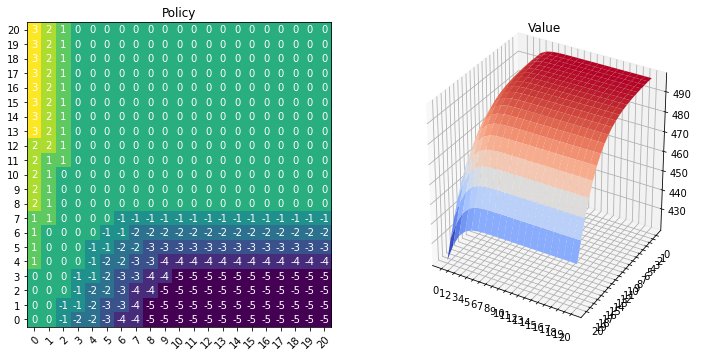

In [13]:
env = Env()
env.policy_evaluation()
env.policy_improvement()
env.plot()

Running policy evaluation
Max diff: 28.856593024926497
Max diff: 4.591600579384419
Max diff: 3.11905154995236
Max diff: 1.4177942135976878
Max diff: 0.6988663200144174
Max diff: 0.39522678092282604
Max diff: 0.2507848043770764
Max diff: 0.17234691106733635
Max diff: 0.12474385301391067
Max diff: 0.09339730743232622
Max diff: 0.07153915703264602
Max diff: 0.0556766564920963
Max diff: 0.04383732540185292
Max diff: 0.03482106150943309
Max diff: 0.027852375942586605
Max diff: 0.022405699628848197
Max diff: 0.018111356079430152
Max diff: 0.014701738456835756
Max diff: 0.011978782524920462
Max diff: 0.009793358404692754
Max diff: 0.008031671534638463
Max diff: 0.006605972890440626
Max diff: 0.00544802621521967
Max diff: 0.0045044028406096
Max diff: 0.0037330263601234037
Max diff: 0.0031005952682221505
Max diff: 0.0025806364450318142
Max diff: 0.0021520204126659337
Max diff: 0.0017978197562911191
Max diff: 0.0015044256532519285
Max diff: 0.0012608604380943689
Max diff: 0.001058240194481641
Ma

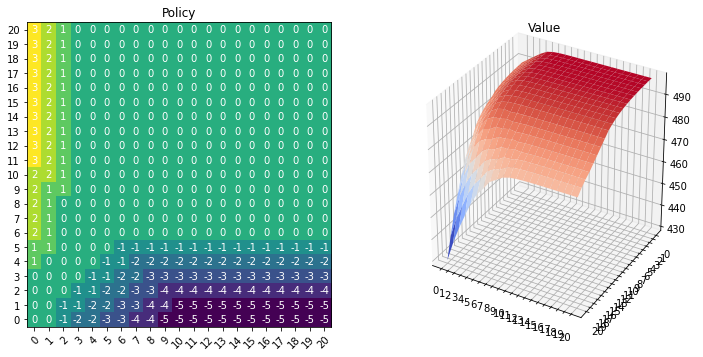

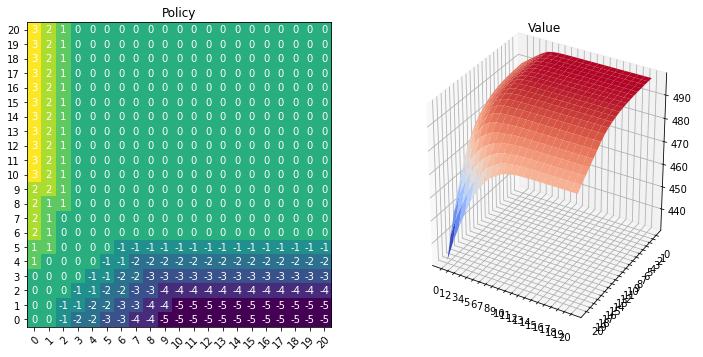

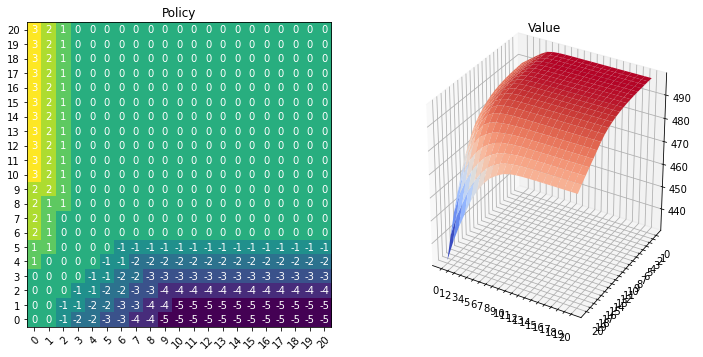

In [14]:
from tqdm.notebook import tqdm
for _ in tqdm(range(10)):
    env.policy_evaluation()
    stable = env.policy_improvement()
    env.plot()
    if stable:
        break